# Goals for this Project

- [x] Import the data
- [x] Drop the Null values
- [x] Drop the index column
- [x] Check out the count and types for genres
- [x] Check out value counts per artists
- [x] Do a groupby per artist
    - [ ] Figure out way to loop through songs for each artist
- [ ] Integrate fuzzywuzzy to delete duplicate songs based on song name matching of a certain percentage to avoid bias
    - [ ] Write loop that enables to compare two songs and if the value is higher than a certain percentage, discard that one. If it's not, then keep it and move along.
- [ ] Run data cleaning measures, cleaning lyrics of stop words common to music (chorus, intro, outro, bridge, etc.)
- [ ] Do a train, test, split on the data for random sample and test data to work with
- [ ] Use Scikit and check out how to run SVMs on train and test data
- [ ] Check out percentages
- [ ] Tweak SVMs based on outcome?
- [ ] Report findings

In [85]:
#importing necessary modules
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import regex as re
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

In [2]:
#reading in the lyrics dataset
lyrics = pd.read_csv('lyrics.csv')

In [58]:
#checking out the first few lines
lyrics.head()

song  year           artist genre  \
0        ego-remix  2009  beyonce-knowles   Pop   
1     then-tell-me  2009  beyonce-knowles   Pop   
2          honesty  2009  beyonce-knowles   Pop   
3  you-are-my-rock  2009  beyonce-knowles   Pop   
4    black-culture  2009  beyonce-knowles   Pop   

                                              lyrics  
0  Oh baby, how you doing?\nYou know I'm gonna cu...  
1  playin' everything so easy,\nit's like you see...  
2  If you search\nFor tenderness\nIt isn't hard t...  
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...  
4  Party the people, the people the party it's po...

In [40]:
#checking if there is anything out of the ordinary in terms of consistency
#we see that there are almost 100,000 songs that do not have lyrics, so we can get rid of those
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266556 entries, 0 to 362236
Data columns (total 6 columns):
index     266556 non-null int64
song      266556 non-null object
year      266556 non-null int64
artist    266556 non-null object
genre     266556 non-null object
lyrics    266556 non-null object
dtypes: int64(2), object(4)
memory usage: 24.2+ MB


In [5]:
#dropping any rows that have no lyrics
lyrics = lyrics.dropna()

In [6]:
#checking to make sure that all the empty rows were dropped and it looks like they were
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266556 entries, 0 to 362236
Data columns (total 6 columns):
index     266556 non-null int64
song      266556 non-null object
year      266556 non-null int64
artist    266556 non-null object
genre     266556 non-null object
lyrics    266556 non-null object
dtypes: int64(2), object(4)
memory usage: 14.2+ MB


In [57]:
lyrics = lyrics.drop(columns=['index'])

In [19]:
#using to get an idea of range of years we have in this data set and it seems to be mostly from 2000's
lyrics.year.describe()

count    266556.000000
mean       2007.654909
std          10.115249
min          67.000000
25%        2006.000000
50%        2007.000000
75%        2010.000000
max        2016.000000
Name: year, dtype: float64

In [9]:
#checking all the unique genres in the dataset. It seem there are about 11 and one Not Available
genres = lyrics['genre'].unique()
print(genres)

['Pop' 'Hip-Hop' 'Not Available' 'Rock' 'Metal' 'Other' 'Country' 'Jazz'
 'Electronic' 'Folk' 'R&B' 'Indie']


In [10]:
#checking out how many songs belong to each genre. It seems like Rock accounts for about 40% of the dataset
genres_count = lyrics.genre.value_counts()
print(genres_count)

Rock             109235
Pop               40466
Hip-Hop           24850
Not Available     23941
Metal             23759
Country           14387
Jazz               7970
Electronic         7966
Other              5189
R&B                3401
Indie              3149
Folk               2243
Name: genre, dtype: int64


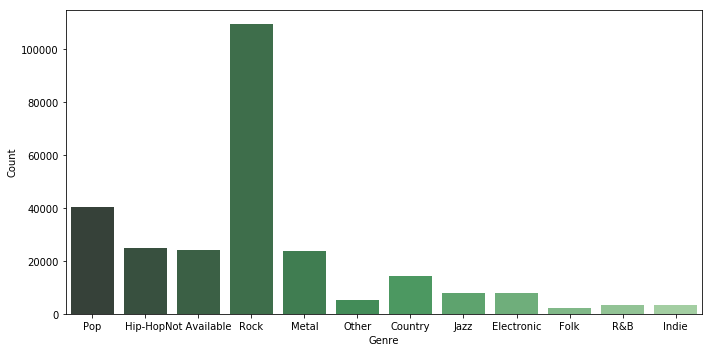

In [11]:
#putting it in a plot just to get an idea
plt.figure(figsize=(10,5))
sns.countplot(x='genre', data=lyrics, palette='Greens_d')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.tight_layout()

In [82]:
#checking how many artists songs are in the dataset. It seems like there may be a lot of duplicates
#I don't think there could be as many as 450 to 700 songs from each of these artists

artists_group = lyrics.groupby("artist")
print(len(artists_group.artist.count()))
artists_group.count().sort_values(by='song', ascending=False).head(50)

14543


song  year  genre  lyrics
artist                                             
dolly-parton               744   744    744     744
elton-john                 676   676    676     676
chris-brown                628   628    628     628
barbra-streisand           607   607    607     607
bob-dylan                  596   596    596     596
eddy-arnold                591   591    591     591
bee-gees                   591   591    591     591
eminem                     578   578    578     578
ella-fitzgerald            571   571    571     571
david-bowie                570   570    570     570
american-idol              568   568    568     568
dean-martin                560   560    560     560
b-b-king                   543   543    543     543
celine-dion                540   540    540     540
elvis-costello             522   522    522     522
bruce-springsteen          509   509    509     509
beach-boys                 495   495    495     495
bill-anderson              466   466    466     466
eric-clapton               461   461    461     461
frank-zappa                457   457    457     457
chumbawamba                423   423    423     423
chicago                    421   421    421     421
frank-sinatra              417   417    417     417
beatles                    416   416    416     416
britney-spears             407   407    407     407
50-cent                    398   398    398     398
diana-ross                 398   398    398     398
chamillionaire             396   396    396     396
emmylou-harris             387   387    387     387
bon-jovi                   383   383    383     383
barry-manilow              375   375    375     375
drake                      373   373    373     373
fall                       368   368    368     368
babyface                   367   367    367     367
2pac                       367   367    367     367
elvis-presley              362   362    362     362
die-toten-hosen            361   361    361     361
conway-twitty              355   355    355     355
electric-light-orchestra   347   347    347     347
game                       341   341    341     341
fleetwood-mac              333   333    333     333
buck-owens                 323   323    323     323
alice-cooper               321   321    321     321
beck                       317   317    317     317
billie-holiday             315   315    315     315
cliff-richard              311   311    311     311
ferlin-husky               306   306    306     306
gary-numan                 305   305    305     305
bad-religion               301   301    301     301
andrea-bocelli             298   298    298     298

In [48]:
#checking output for the groups. Looks to output the indexes for the songs. Will use this for iterating through
#the song names and removing duplicates
artists = artists_group.groups
artists['dolly-parton']

Int64Index([129331, 129332, 129333, 129334, 129335, 129336, 129337, 129338,
            129339, 129340,
            ...
            130076, 130077, 130078, 130079, 130080, 130081, 130082, 130083,
            130084, 130085],
           dtype='int64', length=744)

In [68]:
#checking to see if there are duplicate songs in the dataset
dolly = lyrics[lyrics['artist'] == 'elton-john']
dolly.sort_values(by = 'song').head(50)

song  year      artist genre  \
328887                            20th-century-blues  2006  elton-john  Rock   
328981                       71-75-new-oxford-street  2006  elton-john  Rock   
328812                  a-dandelion-dies-in-the-wind  2006  elton-john  Rock   
328629                             a-dream-come-true  2010  elton-john  Rock   
329002                                  a-good-heart  2016  elton-john  Rock   
328793                                  a-simple-man  2006  elton-john  Rock   
328967                                a-step-too-far  2006  elton-john  Rock   
328603                         a-town-called-jubilee  2013  elton-john  Rock   
329089                               a-woman-s-needs  1993  elton-john  Rock   
329128                             a-word-in-spanish  1990  elton-john  Rock   
328852                                 abide-with-me  2006  elton-john  Rock   
328506                                    act-of-war  1985  elton-john  Rock   
329091             ain-t-nothing-like-the-real-thing  1993  elton-john  Rock   
328880                         all-across-the-havens  2006  elton-john  Rock   
328515                all-quiet-on-the-western-front  1982  elton-john  Rock   
328523                          all-that-i-m-allowed  2004  elton-john  Rock   
328692                      all-the-girls-love-alice  1973  elton-john  Rock   
328670                               all-the-nasties  1996  elton-john  Rock   
328567                   all-the-way-down-to-el-paso  2007  elton-john  Rock   
328693                all-the-young-girls-love-alice  1973  elton-john  Rock   
329061                                     amazes-me  1989  elton-john  Rock   
328579                                          amen  2007  elton-john  Rock   
329084                             american-triangle  2001  elton-john  Rock   
328707                                amneris-letter  2006  elton-john  Rock   
329007                                      amoreena  1971  elton-john  Rock   
329117                                           amy  1990  elton-john  Rock   
328945                      and-the-clock-goes-round  2006  elton-john  Rock   
328796                       and-the-house-fell-down  2006  elton-john  Rock   
328974                                    angel-tree  2006  elton-john  Rock   
328582                                      angeline  1986  elton-john  Rock   
328961                           annabella-umberella  2006  elton-john  Rock   
328959                               another-pyramid  2006  elton-john  Rock   
328542                             answer-in-the-sky  2004  elton-john  Rock   
328551                        are-you-ready-for-love  2007  elton-john  Rock   
328544  are-you-ready-for-love-79-version-radio-edit  2007  elton-john  Rock   
328770                               baby-i-miss-you  2006  elton-john  Rock   
329012                          bad-side-of-the-moon  1971  elton-john  Rock   
328510                                ball-and-chain  1982  elton-john  Rock   
328654                    ballad-of-a-well-known-gun  1996  elton-john  Rock   
329081            ballad-of-the-boy-in-the-red-shoes  2001  elton-john  Rock   
328891                                        basque  2006  elton-john  Rock   
329045                                       belfast  1995  elton-john  Rock   
329044                                       believe  1995  elton-john  Rock   
329104                           bennie-and-the-jets  2000  elton-john  Rock   
328679                               bennie-the-jets  1973  elton-john  Rock   
328568                          bennie-the-jets-live  2007  elton-john  Rock   
328533                               better-off-dead  2004  elton-john  Rock   
329019                  between-seventeen-and-twenty  1997  elton-john  Rock   
329143                                    bid-dipper  1990  elton-john  Rock   
328794                                    big-di

In [94]:
#test case for iterating through artists songs
for index in artists['candy-roach']:
    print(lyrics.song[index])
    

echo-ing
vaznity


In [100]:
for name, group in artists_group:
    print(name)
    for row in group:
        print(row)

009-sound-system
song
year
artist
genre
lyrics
047
song
year
artist
genre
lyrics
0510
song
year
artist
genre
lyrics
0510-ent
song
year
artist
genre
lyrics
1-800-zombie
song
year
artist
genre
lyrics
1-girl-nation
song
year
artist
genre
lyrics
1-hundredd
song
year
artist
genre
lyrics
10-cc
song
year
artist
genre
lyrics
10-years
song
year
artist
genre
lyrics
100-demons
song
year
artist
genre
lyrics
100-monkeys
song
year
artist
genre
lyrics
100-percent
song
year
artist
genre
lyrics
10000-maniacs
song
year
artist
genre
lyrics
1000mods
song
year
artist
genre
lyrics
104
song
year
artist
genre
lyrics
10cm
song
year
artist
genre
lyrics
10digits
song
year
artist
genre
lyrics
10ille
song
year
artist
genre
lyrics
11-11
song
year
artist
genre
lyrics
112
song
year
artist
genre
lyrics
1140-mississippi
song
year
artist
genre
lyrics
11th-hour
song
year
artist
genre
lyrics
12-rounds
song
year
artist
genre
lyrics
12-stones
song
year
artist
genre
lyrics
12am
song
year
artist
genre
lyrics
13-engines
song
y

song
year
artist
genre
lyrics
8-foot-sativa
song
year
artist
genre
lyrics
8-stops-7
song
year
artist
genre
lyrics
801
song
year
artist
genre
lyrics
88-fingers-loui
song
year
artist
genre
lyrics
883
song
year
artist
genre
lyrics
888
song
year
artist
genre
lyrics
8mm
song
year
artist
genre
lyrics
9-days
song
year
artist
genre
lyrics
9-lives-and-counting
song
year
artist
genre
lyrics
911
song
year
artist
genre
lyrics
94-east
song
year
artist
genre
lyrics
98-degrees
song
year
artist
genre
lyrics
9811
song
year
artist
genre
lyrics
99-posse
song
year
artist
genre
lyrics
99-souls
song
year
artist
genre
lyrics
999
song
year
artist
genre
lyrics
9mm-parabellum-bullet
song
year
artist
genre
lyrics
9nine
song
year
artist
genre
lyrics
9rhyme
song
year
artist
genre
lyrics
9th-wonder
song
year
artist
genre
lyrics
a
song
year
artist
genre
lyrics
a-a-bondy
song
year
artist
genre
lyrics
a-aa1a-a-a-a1
song
year
artist
genre
lyrics
a-ap-ant
song
year
artist
genre
lyrics
a-b
song
year
artist
genre
lyrics
a

song
year
artist
genre
lyrics
abraham-mcdonald
song
year
artist
genre
lyrics
abraira
song
year
artist
genre
lyrics
abram-shook
song
year
artist
genre
lyrics
abramelin
song
year
artist
genre
lyrics
abrams-rita
song
year
artist
genre
lyrics
abrasive-wheels
song
year
artist
genre
lyrics
abraxas
song
year
artist
genre
lyrics
abreu-fernanda
song
year
artist
genre
lyrics
abrial-patrick
song
year
artist
genre
lyrics
abrina
song
year
artist
genre
lyrics
abrunhosa-pedro
song
year
artist
genre
lyrics
abrupto-grande
song
year
artist
genre
lyrics
abs
song
year
artist
genre
lyrics
abscess
song
year
artist
genre
lyrics
absent-friends
song
year
artist
genre
lyrics
absentstar
song
year
artist
genre
lyrics
abser
song
year
artist
genre
lyrics
abserdo
song
year
artist
genre
lyrics
absolut-p
song
year
artist
genre
lyrics
absolute
song
year
artist
genre
lyrics
absolute-beginner
song
year
artist
genre
lyrics
absolutely-free
song
year
artist
genre
lyrics
absolution-project
song
year
artist
genre
lyrics
abstr

genre
lyrics
after-the-sirens
song
year
artist
genre
lyrics
after-three-seconds
song
year
artist
genre
lyrics
afterhours
song
year
artist
genre
lyrics
afterlife
song
year
artist
genre
lyrics
aftermoon
song
year
artist
genre
lyrics
afterphase
song
year
artist
genre
lyrics
afters
song
year
artist
genre
lyrics
afterschool
song
year
artist
genre
lyrics
aftershock
song
year
artist
genre
lyrics
afterworld
song
year
artist
genre
lyrics
aftrhours
song
year
artist
genre
lyrics
afu-ra
song
year
artist
genre
lyrics
against-all-authority
song
year
artist
genre
lyrics
against-grace
song
year
artist
genre
lyrics
against-me
song
year
artist
genre
lyrics
against-the-current
song
year
artist
genre
lyrics
agalloch
song
year
artist
genre
lyrics
agans-craig
song
year
artist
genre
lyrics
agastya
song
year
artist
genre
lyrics
agathocles
song
year
artist
genre
lyrics
agathodaimon
song
year
artist
genre
lyrics
age-9
song
year
artist
genre
lyrics
age-aleksandersen
song
year
artist
genre
lyrics
age-of-daze
song

song
year
artist
genre
lyrics
alberto-donatelli
song
year
artist
genre
lyrics
alberto-monnar
song
year
artist
genre
lyrics
albita
song
year
artist
genre
lyrics
alborosie
song
year
artist
genre
lyrics
alc-mass-chior
song
year
artist
genre
lyrics
alcatrazz
song
year
artist
genre
lyrics
alcazar
song
year
artist
genre
lyrics
alcest
song
year
artist
genre
lyrics
alcheh-hunt
song
year
artist
genre
lyrics
alchemist
song
year
artist
genre
lyrics
alcione
song
year
artist
genre
lyrics
aldebert
song
year
artist
genre
lyrics
alden-richards
song
year
artist
genre
lyrics
aldhi-chipenk
song
year
artist
genre
lyrics
aldivas-x-emeline
song
year
artist
genre
lyrics
aldo
song
year
artist
genre
lyrics
aldo-nova
song
year
artist
genre
lyrics
ale-jhay
song
year
artist
genre
lyrics
ale-mrthller
song
year
artist
genre
lyrics
alec-benjamin
song
year
artist
genre
lyrics
alec-gollan
song
year
artist
genre
lyrics
alecia-elliott
song
year
artist
genre
lyrics
alecia-nugent
song
year
artist
genre
lyrics
alectra
song

genre
lyrics
altessa
song
year
artist
genre
lyrics
altiyan-childs
song
year
artist
genre
lyrics
aluminium-risk
song
year
artist
genre
lyrics
alunageorge
song
year
artist
genre
lyrics
alus
song
year
artist
genre
lyrics
aluto
song
year
artist
genre
lyrics
alux-nahual
song
year
artist
genre
lyrics
alva-leigh
song
year
artist
genre
lyrics
alvar-lake
song
year
artist
genre
lyrics
alvaro-soler
song
year
artist
genre
lyrics
alvaro-torres
song
year
artist
genre
lyrics
alvi-khan
song
year
artist
genre
lyrics
alvin
song
year
artist
genre
lyrics
alvin-attai
song
year
artist
genre
lyrics
alvin-lee
song
year
artist
genre
lyrics
alvin-lee-ten-years-after
song
year
artist
genre
lyrics
alvin-stardust
song
year
artist
genre
lyrics
alvin-the-chipmunks
song
year
artist
genre
lyrics
alvin-youngblood-hart
song
year
artist
genre
lyrics
alvvays
song
year
artist
genre
lyrics
alwin-augustine-vishnu-shyam-abin-sagar
song
year
artist
genre
lyrics
aly-aj
song
year
artist
genre
lyrics
aly-michalka
song
year
artist

amy-can-flyy
song
year
artist
genre
lyrics
amy-courts
song
year
artist
genre
lyrics
amy-dalley
song
year
artist
genre
lyrics
amy-diamond
song
year
artist
genre
lyrics
amy-grant
song
year
artist
genre
lyrics
amy-hef
song
year
artist
genre
lyrics
amy-heffernan
song
year
artist
genre
lyrics
amy-helm
song
year
artist
genre
lyrics
amy-kuney
song
year
artist
genre
lyrics
amy-lavere
song
year
artist
genre
lyrics
amy-lee
song
year
artist
genre
lyrics
amy-macdonald
song
year
artist
genre
lyrics
amy-mcdonald
song
year
artist
genre
lyrics
amy-meredith
song
year
artist
genre
lyrics
amy-pearson
song
year
artist
genre
lyrics
amy-ray
song
year
artist
genre
lyrics
amy-rigby
song
year
artist
genre
lyrics
amy-schumer
song
year
artist
genre
lyrics
amy-search
song
year
artist
genre
lyrics
amy-sinha
song
year
artist
genre
lyrics
amy-sky
song
year
artist
genre
lyrics
amy-speace
song
year
artist
genre
lyrics
amy-steele
song
year
artist
genre
lyrics
amy-stroup
song
year
artist
genre
lyrics
amy-studt
song
year

andrew-lloyd-webber-tim-rice
song
year
artist
genre
lyrics
andrew-lloyd-weber
song
year
artist
genre
lyrics
andrew-london
song
year
artist
genre
lyrics
andrew-lowden
song
year
artist
genre
lyrics
andrew-mcmahon
song
year
artist
genre
lyrics
andrew-mcmahon-in-the-wilderness
song
year
artist
genre
lyrics
andrew-michael-harris
song
year
artist
genre
lyrics
andrew-peterson
song
year
artist
genre
lyrics
andrew-powell
song
year
artist
genre
lyrics
andrew-ripp
song
year
artist
genre
lyrics
andrew-s-room
song
year
artist
genre
lyrics
andrew-sisters
song
year
artist
genre
lyrics
andrew-spice
song
year
artist
genre
lyrics
andrew-stockdale
song
year
artist
genre
lyrics
andrew-tan
song
year
artist
genre
lyrics
andrew-w-jones
song
year
artist
genre
lyrics
andrew-wk
song
year
artist
genre
lyrics
andrews-julie
song
year
artist
genre
lyrics
andrews-sisters
song
year
artist
genre
lyrics
andreya-triana
song
year
artist
genre
lyrics
android-lust
song
year
artist
genre
lyrics
andromeda
song
year
artist
ge

ann-nesby
song
year
artist
genre
lyrics
ann-peebles
song
year
artist
genre
lyrics
ann-sophie
song
year
artist
genre
lyrics
ann-wilson
song
year
artist
genre
lyrics
ann-winsborn
song
year
artist
genre
lyrics
anna-aaron
song
year
artist
genre
lyrics
anna-abreu
song
year
artist
genre
lyrics
anna-calvi
song
year
artist
genre
lyrics
anna-carina
song
year
artist
genre
lyrics
anna-chedid
song
year
artist
genre
lyrics
anna-clendening
song
year
artist
genre
lyrics
anna-f
song
year
artist
genre
lyrics
anna-graceman
song
year
artist
genre
lyrics
anna-kendrick
song
year
artist
genre
lyrics
anna-livi
song
year
artist
genre
lyrics
anna-mae
song
year
artist
genre
lyrics
anna-margaret
song
year
artist
genre
lyrics
anna-mcluckie
song
year
artist
genre
lyrics
anna-naklab
song
year
artist
genre
lyrics
anna-nalick
song
year
artist
genre
lyrics
anna-oxa
song
year
artist
genre
lyrics
anna-puu
song
year
artist
genre
lyrics
anna-rossinelli
song
year
artist
genre
lyrics
anna-tatangelo
song
year
artist
genre
ly

ariez-onasis
song
year
artist
genre
lyrics
arif-maulana
song
year
artist
genre
lyrics
arijit-singh
song
year
artist
genre
lyrics
arisa
song
year
artist
genre
lyrics
arise
song
year
artist
genre
lyrics
arjan-brass
song
year
artist
genre
lyrics
arjay-sharp
song
year
artist
genre
lyrics
arjen-anthony-lucassen
song
year
artist
genre
lyrics
arjona
song
year
artist
genre
lyrics
arjun
song
year
artist
genre
lyrics
ark-patrol
song
year
artist
genre
lyrics
arkan
song
year
artist
genre
lyrics
arkansas-gospel-mass-choir
song
year
artist
genre
lyrics
arkarna
song
year
artist
genre
lyrics
arkells
song
year
artist
genre
lyrics
arkham-karvers
song
year
artist
genre
lyrics
arkona
song
year
artist
genre
lyrics
arlanzo
song
year
artist
genre
lyrics
arlen-roth
song
year
artist
genre
lyrics
arlisa
song
year
artist
genre
lyrics
arlissa
song
year
artist
genre
lyrics
arlo-guthrie
song
year
artist
genre
lyrics
armaan-ali
song
year
artist
genre
lyrics
armaan-malik
song
year
artist
genre
lyrics
armada-blue
song

asim-raza
song
year
artist
genre
lyrics
asimastrica
song
year
artist
genre
lyrics
asin
song
year
artist
genre
lyrics
ask-embla
song
year
artist
genre
lyrics
aska
song
year
artist
genre
lyrics
aska-yang
song
year
artist
genre
lyrics
askil-holm
song
year
artist
genre
lyrics
asking-alexandria
song
year
artist
genre
lyrics
asleep-at-the-wheel
song
year
artist
genre
lyrics
aslyn
song
year
artist
genre
lyrics
asobi-seksu
song
year
artist
genre
lyrics
asp
song
year
artist
genre
lyrics
aspektz
song
year
artist
genre
lyrics
asphyx
song
year
artist
genre
lyrics
asrai
song
year
artist
genre
lyrics
ass-ponys
song
year
artist
genre
lyrics
assagai
song
year
artist
genre
lyrics
assassin
song
year
artist
genre
lyrics
assata-shakur
song
year
artist
genre
lyrics
assduan-ck
song
year
artist
genre
lyrics
assemblage-23
song
year
artist
genre
lyrics
assembly-of-dust
song
year
artist
genre
lyrics
assgass
song
year
artist
genre
lyrics
association
song
year
artist
genre
lyrics
asspera
song
year
artist
genre
ly

aurora-vice
song
year
artist
genre
lyrics
aurorealis
song
year
artist
genre
lyrics
auryn
song
year
artist
genre
lyrics
aus-rotten
song
year
artist
genre
lyrics
aussie-rugby
song
year
artist
genre
lyrics
austen-leathers
song
year
artist
genre
lyrics
austin-ally
song
year
artist
genre
lyrics
austin-and-andy
song
year
artist
genre
lyrics
austin-corini
song
year
artist
genre
lyrics
austin-dickerson
song
year
artist
genre
lyrics
austin-jenckes
song
year
artist
genre
lyrics
austin-lounge-lizards
song
year
artist
genre
lyrics
austin-mahone
song
year
artist
genre
lyrics
austin-moon
song
year
artist
genre
lyrics
austin-moon-ross-lynch-and-ally-dawson-laura-marano
song
year
artist
genre
lyrics
austin-morris
song
year
artist
genre
lyrics
austin-plaine
song
year
artist
genre
lyrics
austin-sampson
song
year
artist
genre
lyrics
austin-webb
song
year
artist
genre
lyrics
austins-bridge
song
year
artist
genre
lyrics
austra
song
year
artist
genre
lyrics
australian-crawl
song
year
artist
genre
lyrics
aus

song
year
artist
genre
lyrics
b-o-b
song
year
artist
genre
lyrics
b-project
song
year
artist
genre
lyrics
b-ray
song
year
artist
genre
lyrics
b-real
song
year
artist
genre
lyrics
b-real-coolio-busta-rhymes-ll-cool-j-method-man
song
year
artist
genre
lyrics
b-rish
song
year
artist
genre
lyrics
b-scott
song
year
artist
genre
lyrics
b-smyth
song
year
artist
genre
lyrics
b-story
song
year
artist
genre
lyrics
b-tight
song
year
artist
genre
lyrics
b-w-stevenson
song
year
artist
genre
lyrics
b-will
song
year
artist
genre
lyrics
b-witched
song
year
artist
genre
lyrics
b-yellow
song
year
artist
genre
lyrics
b-z
song
year
artist
genre
lyrics
b0r5t
song
year
artist
genre
lyrics
b1a4
song
year
artist
genre
lyrics
b2k
song
year
artist
genre
lyrics
b3
song
year
artist
genre
lyrics
b4
song
year
artist
genre
lyrics
b4-4
song
year
artist
genre
lyrics
b5
song
year
artist
genre
lyrics
baaba-maal
song
year
artist
genre
lyrics
baader-meinhof
song
year
artist
genre
lyrics
baauer
song
year
artist
genre
lyric

KeyboardInterrupt: 

In [97]:
for name, group in artists_group:
    if len(group) > 1:
        for row in group:
            print(row)
#             song1 = lyrics
#             song2 = row.song
#             if fuzz.ratio(song1, song2) > 80:
#                 lyrics = lyrics.drop(lyrics.lyrics.iloc[index])
    print(group)

song
year
artist
genre
lyrics
                     song  year            artist genre  \
331868  born-to-be-wasted  2011  009-sound-system   Pop   
331869    speak-to-angels  2015  009-sound-system   Pop   
331870     space-and-time  2015  009-sound-system   Pop   
331871      with-a-spirit  2014  009-sound-system   Pop   

                                                   lyrics  
331868  Oh the beat's gonna bash gonna break it up\nTh...  
331869  I was there when Jesus came down from the cros...  
331870  Yeah I remember in space and time\nAnd I remem...  
331871  You can be\nWhatever you want\nWhen you're hig...  
                       song  year artist genre  \
271937  keep-it-to-yourself  2014    047   Pop   

                                                   lyrics  
271937  Aaah, ah-aaah\nIs it time for me to leave?\nHa...  
            song  year artist          genre  \
155200  monsters  2013   0510  Not Available   

                                                   lyric

252760  Jus' look at them\nI tell you, it warms the he...  
              song  year         artist          genre  \
97122  cutest-girl  2013  2-night-starz  Not Available   

                                                  lyrics  
97122  First verse, i wanna tell ya something.\nlet m...  
song
year
artist
genre
lyrics
                         song  year     artist    genre  \
287425       put-it-n-ya-life  2009  2-pistols  Hip-Hop   
287426               get-away  2009  2-pistols  Hip-Hop   
287427               hot-damn  2009  2-pistols  Hip-Hop   
287428             text-buddy  2010  2-pistols  Hip-Hop   
287430            redonkulous  2010  2-pistols  Hip-Hop   
287431         private-dancer  2010  2-pistols  Hip-Hop   
287436             we-made-it  2011  2-pistols  Hip-Hop   
287438            up-and-down  2008  2-pistols  Hip-Hop   
287440  candy-coated-diamonds  2008  2-pistols  Hip-Hop   
287441  death-before-dishonor  2008  2-pistols  Hip-Hop   
287443        from-the-bot

69846  2 von millionen von sternen\ndie sich immer me...  
           song  year artist  genre  \
289802  amazing  2016    2sc  Other   

                                                   lyrics  
289802  (Verse 1)\nI'll build you up\nNo I won't break...  
song
year
artist
genre
lyrics
                     song  year   artist  genre  \
239465         1-way-2-go  2016  2shaddy  Other   
239466  came-here-2-party  2016  2shaddy  Other   
239467            monster  2016  2shaddy  Other   
239468       test-ya-luck  2015  2shaddy  Other   
239469      what-they-say  2015  2shaddy  Other   
239470  fly-like-an-eagle  2015  2shaddy  Other   
239471        whatcha-say  2015  2shaddy  Other   

                                                   lyrics  
239465  [Intro]\nYea\nUh huh\n[Verse]\nI been working ...  
239466  [Intro: Joker]\nTell me' something my friend\n...  
239467  Someone call Usher' I want a deal homie\nMy he...  
239468  [Verse]\n1 2 3 to the 4\nKnock knock, who's th...  
239

169701  From the cradle to the grave\nThe Oi Boy tryin...  
                      song  year     artist          genre  \
26701  are-pain-and-misery  2013  4-strikes  Not Available   

                                                  lyrics  
26701  if you could would you help me end it all end ...  
song
year
artist
genre
lyrics
                                               song  year     artist  \
97850                                  take-me-away  2006  4-strings   
97851                                   let-it-rain  2006  4-strings   
97852                                        diving  2008  4-strings   
97853                                  living-a-lie  2008  4-strings   
97854                                       believe  2008  4-strings   
97855                          all-around-the-world  2008  4-strings   
97856                                       daytime  2008  4-strings   
97857                                         outro  2008  4-strings   
97858              

38987  Livin' life, dealin' you've got feathers in yo...  
song
year
artist
genre
lyrics
                              song  year artist genre  \
292857                word-iz-bond  2006    702   Pop   
292858            i-still-love-you  2006    702   Pop   
292859                  all-i-want  2006    702   Pop   
292860                       seven  2006    702   Pop   
292861       come-knock-on-my-door  2006    702   Pop   
292862                      no-way  2006    702   Pop   
292863           where-my-girls-at  2006    702   Pop   
292864      you-ll-just-never-know  2006    702   Pop   
292865             get-it-together  2006    702   Pop   
292866                      places  2006    702   Pop   
292867                 gotta-leave  2006    702   Pop   
292868                   make-time  2006    702   Pop   
292869            show-you-my-love  2006    702   Pop   
292870              you-don-t-know  2006    702   Pop   
292871           get-down-like-dat  2006    702   Pop   

70206  Upon a throne of doubt I sat\nContemplating wh...  
song
year
artist
genre
lyrics
                                   song  year             artist  genre  \
213612  i-ve-seen-prettier-in-amsterdam  2009  a-broken-tomorrow  Metal   
213613           when-they-were-sinking  2009  a-broken-tomorrow  Metal   

                                                   lyrics  
213612  This is the part where we change the world\nAn...  
213613  He with power, strike me down\nRedden my seas ...  
song
year
artist
genre
lyrics
                                         song  year                   artist  \
182477  i-will-destroy-the-wisdom-of-the-wise  2012  a-bullet-for-pretty-boy   
182488                           the-prodigal  2014  a-bullet-for-pretty-boy   

        genre                                             lyrics  
182477  Metal  [Intro] x2\nI cant look at what weve done\nAnd...  
182488  Metal  Restless to the ignorance.\nThe painting pictu...  
song
year
artist
genre
lyrics
   

                     song  year      artist genre  \
194707  where-is-my-daddy  2013  a-t-m-jeff   Pop   
194708        get-you-wet  2012  a-t-m-jeff   Pop   
194709           under-18  2012  a-t-m-jeff   Pop   
194710     it-s-true-love  2012  a-t-m-jeff   Pop   
194711           love-you  2012  a-t-m-jeff   Pop   

                                                   lyrics  
194707  (Hook)\nCan somebody tell me ummm!\nCan somebo...  
194708  Yeah Yeahhhhhhhh!\nlay your body down girl, la...  
194709  intro\nA.T.M JEFF, Tanzania Bongo flava\nTAO B...  
194710  Chorus\nIt's true love, baby girl I just wanna...  
194711  1 Chorus\nYeeeeeeeeeeh baby girl is still me A...  
              song  year       artist  genre  \
281249  they-on-me  2016  a-t-m-quote  Other   

                                                   lyrics  
281249  He's my number one(X6)\nThey keep telling me d...  
song
year
artist
genre
lyrics
               song  year   artist  genre  \
137216        roses  2014  a-

158899  Verse 1:\nWe may feel all alone\nWe may feel l...  
song
year
artist
genre
lyrics
                                 song  year      artist          genre  \
70532               until-i-found-you  2010  aaron-hall  Not Available   
70533         the-places-i-would-kiss  2006  aaron-hall  Not Available   
70534                 don-t-be-afraid  2008  aaron-hall  Not Available   
70535                      i-miss-you  2008  aaron-hall  Not Available   
70536  all-the-places-i-will-kiss-you  2008  aaron-hall  Not Available   
70538                when-you-need-me  2008  aaron-hall  Not Available   

                                                  lyrics  
70532  I was nothing\nUntil I found your love\nTill I...  
70533  Intro:\nThere's so many places i wanna kiss yo...  
70534  There's no need to be afraid, my baby\nI'm as ...  
70535  We used to talk, and laugh all night girl\nWha...  
70536  There's so many places I want to kiss you, bab...  
70538  Who was there for you\nWhen yo

                               song  year artist genre  \
130805     waterloo-english-version  2009   abba   Pop   
130806                     soldiers  2009   abba   Pop   
130807   gonna-sing-you-my-lovesong  2009   abba   Pop   
130808               kisses-of-fire  2009   abba   Pop   
130809           i-wonder-departure  2009   abba   Pop   
...                             ...   ...    ...   ...   
130979               as-good-as-new  2014   abba   Pop   
130980  if-it-wasn-t-for-the-nights  2014   abba   Pop   
130981          take-a-cahnce-on-me  2014   abba   Pop   
130982              i-m-still-alive  2014   abba   Pop   
130983            hole-in-your-soul  2014   abba   Pop   

                                                   lyrics  
130805  My my\nAt Waterloo Napoleon did surrender\nOh ...  
130806  Do I hear what I think I'm hearin'?\nDo I see ...  
130807  You say she's been mad at you\nThen you say yo...  
130808  Lay your head on my chest so you hear every be...  
130

[71 rows x 5 columns]
song
year
artist
genre
lyrics
                    song  year                artist genre  \
16396  nervous-breakdown  2009  abingdon-boys-school  Rock   
16397    innocent-sorrow  2009  abingdon-boys-school  Rock   
16398             as-one  2010  abingdon-boys-school  Rock   
16399           strength  2010  abingdon-boys-school  Rock   
16400           valkyrie  2010  abingdon-boys-school  Rock   
16401            howling  2011  abingdon-boys-school  Rock   

                                                  lyrics  
16396  Tell me why, you never gonna take the ride,\nD...  
16397  Saketa mune no kizuguchi\nNi afure nagareru pa...  
16398  Don't you get this reality\nYou're losing what...  
16399  Kawaita kuchibiru itetsuku taiyou ni sarasaret...  
16400  The world is a battlefield\nWe're in a dark sh...  
16401  A night sky full of cries\nHearts filled with ...  
          song  year     artist  genre  \
316435  lonely  2013  abishiekh  Other   

               

51735  Long ago - in the shade of timberlands\nHorses...  
song
year
artist
genre
lyrics
                                      song  year  artist  genre  \
356199                          permafrost  2007  absurd  Metal   
356200             wenn-walka1-4ren-reiten  2007  absurd  Metal   
356201             germanien-a1-4ber-alles  2007  absurd  Metal   
356202                        sonnenritter  2007  absurd  Metal   
356203               tod-vor-sonnenaufgang  2007  absurd  Metal   
356204                              asatru  2007  absurd  Metal   
356205                         green-heart  2007  absurd  Metal   
356206      gemetzel-in-der-felsenschlucht  2007  absurd  Metal   
356207                          asgardsrei  2007  absurd  Metal   
356208                      eternal-winter  2007  absurd  Metal   
356209                     in-die-schlacht  2007  absurd  Metal   
356210                       mourning-soul  2007  absurd  Metal   
356211                    deep-dark-fore

58264  Ich fahre mit dem Auto durch die Gegend\nUnd d...  
                        song  year                              artist  genre  \
38257  bourbon-street-parade  2001  acker-bilk-chris-barber-kenny-ball  Other   

                                                  lyrics  
38257  Let's fly down, or drive down,\nTo New Orleans...  
song
year
artist
genre
lyrics
                             song  year  artist genre  \
140650        ciertas-tarrkntulas  2006  acolla  Rock   
140651           accimao-n-y-vida  2006  acolla  Rock   
140652              marco-de-aire  2006  acolla  Rock   
140653                 un-autobus  2006  acolla  Rock   
140654                    lignito  2006  acolla  Rock   
140655       atmmao-sfera-esteril  2006  acolla  Rock   
140656                      libre  2006  acolla  Rock   
140657          mago-del-paraguas  2006  acolla  Rock   
140658     ladrmao-n-de-estrellas  2006  acolla  Rock   
140659                  un-autobs  2006  acolla  Rock   
140

236621  Rock  I find myself lost\nFor the first time\nAnd al...  
                    song  year      artist genre  \
268929  what-do-you-want  2011  adam-faith   Pop   

                                                   lyrics  
268929  What do you want if you don't want money\nWhat...  
                           song  year      artist    genre  \
21554  there-s-a-girl-out-there  2013  adam-fears  Country   

                                                  lyrics  
21554  I don't know how many times I've heard it\nYou...  
song
year
artist
genre
lyrics
                                  song  year      artist genre  \
55510                  broken-joystick  2007  adam-green  Rock   
55511                           bungee  2007  adam-green  Rock   
55512                  choke-on-a-cock  2007  adam-green  Rock   
55513                   can-you-see-me  2007  adam-green  Rock   
55514                      bartholemew  2007  adam-green  Rock   
55515                       jolly-good  

           song  year   artist          genre  \
189623  adiemus  2006  adiemus  Not Available   

                                                   lyrics  
189623  heeheeheeheeheeheeheehee.....\nadie adie mus t...  
            song  year      artist          genre  \
240325  official  2013  adil-memon  Not Available   

                                                   lyrics  
240325  The lonely days are over\nLets meet in the mid...  
song
year
artist
genre
lyrics
                                 song  year        artist    genre  \
307425                   sexual-needs  2007  adina-howard  Hip-Hop   
307427            don-t-come-too-fast  2007  adina-howard  Hip-Hop   
307428                      phone-sex  2007  adina-howard  Hip-Hop   
307429                   picture-this  2007  adina-howard  Hip-Hop   
307430                outro-me-to-you  2007  adina-howard  Hip-Hop   
307431                        l-o-v-a  2007  adina-howard  Hip-Hop   
307432                      buttna

song
year
artist
genre
lyrics
                                           song  year         artist  genre  \
222511                              kiss-my-ass  2014  adrija-lokesh  Other   
222512                              she-goes-on  2014  adrija-lokesh  Other   
222513                           another-sunday  2014  adrija-lokesh  Other   
222514  crazy-love-tribute-to-michael-hutchence  2014  adrija-lokesh  Other   
222515                               tough-love  2014  adrija-lokesh  Other   
222516                       reinventing-myself  2014  adrija-lokesh  Other   

                                                   lyrics  
222511  Baby, this will make you feel alright\nIt's ea...  
222512  Verse\nSo her morning starts\nWhen the sun is ...  
222513  Verse 1\nSee the eyes of your lover\ntelling l...  
222514  verse 1\nhello crazy love , lets head out\nto ...  
222515  Tough Love\nTrying to move away,\nbut I can't ...  
222516  Blankly staring at the street\nThinking of all..

                          song  year      artist          genre  \
46421           i-ll-be-strong  2013  after-born  Not Available   
46422       living-like-rebels  2013  after-born  Not Available   
46423  what-are-we-waiting-for  2012  after-born  Not Available   

                                                  lyrics  
46421  Rap\nIn our world, this is my dedication, some...  
46422  Rap:\nI see my real G with a gun to kill and s...  
46423  [Hook: Mikel]\nwhen we were together you were ...  
song
year
artist
genre
lyrics
                                         song  year        artist genre  \
274462  madrigal-love-part-two-over-every-sea  2006  after-crying  Rock   
274463                 madrigal-love-part-one  2006  after-crying  Rock   
274464      shinin-to-the-powers-of-fairyland  2006  after-crying  Rock   
274465  european-things-hommage-a-frank-zappa  2006  after-crying  Rock   
274466                               to-black  2006  after-crying  Rock   
274467         

173491  You're sick of me, and no-one else\nI must agr...  
song
year
artist
genre
lyrics
                             song  year    artist genre  \
280961                      chuck  2007  agent-51  Rock   
280962        san-diego-s-burning  2007  agent-51  Rock   
280963                conditioned  2007  agent-51  Rock   
280964              fuckin-loaded  2007  agent-51  Rock   
280965              kiss-of-death  2007  agent-51  Rock   
280966                  red-alert  2007  agent-51  Rock   
280967           she-s-my-heroine  2007  agent-51  Rock   
280968  deadlines-and-commitments  2007  agent-51  Rock   
280969          boot-to-the-brain  2007  agent-51  Rock   
280970                   aim-high  2007  agent-51  Rock   
280971           homecoming-queen  2007  agent-51  Rock   
280972              wrecking-ball  2007  agent-51  Rock   
280973                     no-way  2007  agent-51  Rock   
280974        5-miles-to-bellevue  2007  agent-51  Rock   
280975               work

                             song  year artist genre  \
12026  akanesasu-everlasting-snow  2016  aimer   Pop   
12027             chouchou-musubi  2016  aimer   Pop   
12028                   akanesasu  2016  aimer   Pop   
12030        everlasting-snow-eaa  2016  aimer   Pop   
12031                     ninelie  2016  aimer   Pop   
12032                 brave-shine  2015  aimer   Pop   
12033               last-stardust  2015  aimer   Pop   
12034               dareka-umi-wo  2014  aimer   Pop   
12035                broken-night  2014  aimer   Pop   

                                                  lyrics  
12026  Kanji:\nIt's just arrived\nä»å¤å¥è·¡ã¯ç©ºã...  
12027  Katappo de maru wo tsukutte shikkari mottete\n...  
12028  Kanji:\nä½è©ï¼aimerrhythm\nä½æ²ï¼é£ä¿è...  
12030  KANJI LYRICS\nIt's just arrived\nä»å¤ãå¥è...  
12031  åãç¹ãç©ºã®æã\nä¸ã¤é³ãç«ã¦ã...  
12032  å·¦æã«é ãã é¡ãã¯é¡ãã®ã¾ã¾ã§...  
12033  Furishikiru tsumeta

                                        song  year     artist  genre  \
206719                 summon-the-antichrist  2008  akercocke  Metal   
206720  footsteps-resound-in-an-empty-chapel  2008  akercocke  Metal   
206721                               promise  2008  akercocke  Metal   
206722                                 epode  2008  akercocke  Metal   
206723                           dark-inside  2008  akercocke  Metal   
206724                     my-apterous-angel  2008  akercocke  Metal   
206725            man-without-faith-or-trust  2008  akercocke  Metal   
206726                                 axiom  2008  akercocke  Metal   

                                                   lyrics  
206719  Master, take wing over the desert\nAnd parched...  
206720  Hear me, the Antichrist is coming\nHe who open...  
206721  Draw near, partake of this altar\nFor you are ...  
206722  Thinking of words\nTo describe you\nNo one can...  
206723  Drink the blood, shadows cast\nFormless fle

                           song  year       artist genre  \
202300     i-got-you-on-my-mind  2012  alain-clark   Pop   
202301                 anything  2012  alain-clark   Pop   
202302             someone-else  2012  alain-clark   Pop   
202303              my-shoulder  2012  alain-clark   Pop   
202304                two-hands  2012  alain-clark   Pop   
202305             blow-me-away  2012  alain-clark   Pop   
202306           happy-birthday  2012  alain-clark   Pop   
202307                   nympho  2012  alain-clark   Pop   
202308  generation-love-revival  2012  alain-clark   Pop   
202309        get-your-savvy-on  2012  alain-clark   Pop   
202310          let-some-air-in  2012  alain-clark   Pop   
202311               release-it  2012  alain-clark   Pop   
202312         woman-inside-you  2012  alain-clark   Pop   
202313         leaf-in-the-wind  2012  alain-clark   Pop   
202314       signal-of-distress  2012  alain-clark   Pop   
202315         bringing-me-love  2012  a

                  song  year    artist    genre  \
22139  bring-the-noise  2012  ale-jhay  Hip-Hop   

                                                  lyrics  
22139  [Intro]\n[Verse 1]\nWhoa Whoa Whoa\nI'm the on...  
         song  year        artist  genre                              lyrics
362219  trilo  2015  ale-mrthller  Other  Trilo!\nHÃ¤r Ã¤r han.\nNÃ¤ra land.
song
year
artist
genre
lyrics
                     song  year         artist genre  \
16915    i-built-a-friend  2016  alec-benjamin   Pop   
16916  i-won-t-forget-you  2016  alec-benjamin   Pop   
16917   end-of-the-summer  2016  alec-benjamin   Pop   
16918         paper-crown  2014  alec-benjamin   Pop   

                                                  lyrics  
16915  I built a friend with three pieces of plastic ...  
16916  When all you can do\nIs turn back around\nWalk...  
16917  When I was fifteen in parent's house\nI met a ...  
16918  A paper crown, and a heart made of glass\nA ta...  
song
year
artist
ge

343660  Like the summer of Sam, back in '69\nI'd be he...  
song
year
artist
genre
lyrics
                            song  year  artist       genre  \
323834                      4-am  2012  alex-g  Electronic   
323855                   be-kind  2016  alex-g  Electronic   
323864                      snot  2015  alex-g  Electronic   
323867                   in-love  2015  alex-g  Electronic   
323868                     ready  2015  alex-g  Electronic   
323869                 brite-boy  2015  alex-g  Electronic   
323870                    thorns  2015  alex-g  Electronic   
323875                    kicker  2015  alex-g  Electronic   
323877                     bones  2014  alex-g  Electronic   
323878  love-the-way-you-miss-me  2014  alex-g  Electronic   
323879         littlemissperfect  2014  alex-g  Electronic   
323880                     proof  2014  alex-g  Electronic   
323881                growing-up  2014  alex-g  Electronic   

                                         

37210  the sunlight has a sister and she's beating do...  
song
year
artist
genre
lyrics
                    song  year     artist          genre  \
98709      zigeunerjunge  2009  alexandra  Not Available   
98710    no-a-sido-facil  2007  alexandra  Not Available   
98711       i-can-t-live  2007  alexandra  Not Available   
98712     weisst-du-noch  2006  alexandra  Not Available   
98713  twist-of-nonsense  2014  alexandra  Not Available   

                                                  lyrics  
98709  Ich war noch ein Kind da kamen Zigeuner Zigeun...  
98710  no sabes como me duele saber que de mi tu ya n...  
98711  I can't live with someone who's always upset w...  
98712  Frühling kam auf den silbernen Schwingen der N...  
98713  this is a song from my heart. this is a secret...  
           song  year            artist          genre  \
265116  perfect  2009  alexandra-berker  Not Available   

                                                   lyrics  
265116  Oh, I was p

5111  Here he comes\nHere comes Speed Racer\nHe's a ...  
song
year
artist
genre
lyrics
                   song  year    artist    genre  \
87118    almost-made-ya  2007  ali-gipp  Hip-Hop   
87119  hard-in-da-paint  2006  ali-gipp  Hip-Hop   
87120      let-em-fight  2008  ali-gipp  Hip-Hop   

                                                  lyrics  
87118  Almost made ya the main thing on my agenda\nWh...  
87119  [Boy]\nThis a Nitti beat!\n[Chorus: Ali & Gipp...  
87120  Let 'em fight (let 'em fight) let 'em fight (l...  
song
year
artist
genre
lyrics
                          song  year      artist genre  \
169400  sharaf-kay-sheher-main  2011  ali-haider   Pop   
169401            purani-jeans  2015  ali-haider   Pop   

                                                   lyrics  
169400  Sharaf kay sheher main\nher ba mo'tar\nhussain...  
169401  Purani jeans aur guitar\nMohalle ki vo chhat\n...  
song
year
artist
genre
lyrics
             song  year    artist genre  \
83287    

                  song  year        artist    genre  \
336193  homeward-bound  2008  alison-brown  Country   
336199           angel  2008  alison-brown  Country   

                                                   lyrics  
336193  I'm sitting in the railway station.\nGot a tic...  
336199  Angel came down from heaven yesterday\nShe sta...  
song
year
artist
genre
lyrics
                song  year       artist  genre  \
235908  chinese-song  2013  alison-gold  Metal   
235909       abcdefg  2013  alison-gold  Metal   
235910  chinese-food  2013  alison-gold  Metal   

                                                   lyrics  
235908  [Verse 1]\nAfter balling, I go clubbing\nThen ...  
235909  [Verse 1]\nA stands for Anything you want to h...  
235910  [Verse 1]\nAfter balling, I go clubbing\nThen ...  
song
year
artist
genre
lyrics
                    song  year        artist  genre  \
265449  chance-for-bliss  2015  alison-james  Other   
265450     at-the-source  2015  alison-jame

211971  Verse 1:\nI was stupid\nI fell off the edge\nC...  
song
year
artist
genre
lyrics
                     song  year                     artist  genre  \
43799               haven  2014  all-the-luck-in-the-world  Indie   
43800            beaching  2014  all-the-luck-in-the-world  Indie   
43801               never  2014  all-the-luck-in-the-world  Indie   
43802  flight-in-the-oaks  2014  all-the-luck-in-the-world  Indie   
43804             conquer  2014  all-the-luck-in-the-world  Indie   
43805          your-fires  2014  all-the-luck-in-the-world  Indie   
43806               knots  2014  all-the-luck-in-the-world  Indie   
43807           dark-eyes  2014  all-the-luck-in-the-world  Indie   
43808              settle  2014  all-the-luck-in-the-world  Indie   
43809                away  2014  all-the-luck-in-the-world  Indie   

                                                  lyrics  
43799  We tore my shirt just back from school\nAnd in...  
43800  And there you stay\nAs yo

                                 song  year           artist genre  \
167285                 clock-runs-out  2010  allstar-weekend  Rock   
167286                            amy  2010  allstar-weekend  Rock   
167287                  here-with-you  2010  allstar-weekend  Rock   
167288            come-down-with-love  2010  allstar-weekend  Rock   
167289                    the-weekend  2010  allstar-weekend  Rock   
167290                    catching-up  2010  allstar-weekend  Rock   
167291            can-t-sleep-tonight  2010  allstar-weekend  Rock   
167292  journey-to-the-end-of-my-life  2010  allstar-weekend  Rock   
167293                   hey-princess  2010  allstar-weekend  Rock   
167294         a-different-side-of-me  2010  allstar-weekend  Rock   
167295                  dance-forever  2010  allstar-weekend  Rock   
167296   i-just-can-t-wait-to-be-king  2010  allstar-weekend  Rock   
167297                  the-last-time  2012  allstar-weekend  Rock   
167298             l

                                 song  year       artist genre  \
331435                 como-un-duende  2010  alux-nahual  Rock   
331436  la-fabula-del-grillo-y-el-mar  2006  alux-nahual  Rock   
331437                hombres-de-maiz  2006  alux-nahual  Rock   
331438              libre-sentimiento  2006  alux-nahual  Rock   
331439                         duende  2006  alux-nahual  Rock   
331440                  alto-al-fuego  2006  alux-nahual  Rock   
331441          dime-que-no-recuerdas  2006  alux-nahual  Rock   
331442            aqui-esta-tu-tierra  2006  alux-nahual  Rock   
331443                 fiesta-privada  2006  alux-nahual  Rock   
331444                          mujer  2006  alux-nahual  Rock   
331445                     toca-viejo  2006  alux-nahual  Rock   
331446                      conquista  2006  alux-nahual  Rock   

                                                   lyrics  
331435  Nacer nunca pidi\nY al pedir nadie le di\nSu c...  
331436  Buenas noches

lyrics
                                 song  year        artist genre  \
168653           god-send-me-an-angel  2009  amanda-perez   Pop   
168654                        hell-no  2004  amanda-perez   Pop   
168655                           fire  2004  amanda-perez   Pop   
168656                  how-u-luv-dat  2004  amanda-perez   Pop   
168657                    calling-you  2004  amanda-perez   Pop   
168658                   make-me-feel  2004  amanda-perez   Pop   
168659                            hoe  2004  amanda-perez   Pop   
168660               i-need-your-love  2004  amanda-perez   Pop   
168661                    get-it-girl  2004  amanda-perez   Pop   
168662                       dedicate  2004  amanda-perez   Pop   
168663                        already  2004  amanda-perez   Pop   
168664                          angel  2004  amanda-perez   Pop   
168665         i-pray-never-forget-it  2004  amanda-perez   Pop   
168666  angel-acoustic-guitar-version  2004  amanda-per

76872  Laying here\nFeeling so rough\nGuess the pink ...  
song
year
artist
genre
lyrics
                             song  year  artist          genre  \
52452   kill-me-and-make-it-quick  2015  amelie  Not Available   
52453  i-don-t-wanna-take-it-slow  2014  amelie  Not Available   

                                                  lyrics  
52452  I heard your sound\ni caught your rhythm\nknoc...  
52453  Letra de I Don't Wanna Take It Slow -\nIn a ne...  
         song  year   artist          genre  \
145755  shine  2013  amelina  Not Available   

                                                   lyrics  
145755  VERSE 1 LYRICS:\nTangu siku, tangu siku za kal...  
song
year
artist
genre
lyrics
                     song  year           artist genre  \
323272          lassitude  2011  amelle-berrabah   Pop   
323273         command-me  2011  amelle-berrabah   Pop   
323274             parade  2011  amelle-berrabah   Pop   
323275  anywhere-the-name  2011  amelle-berrabah   Pop   


12817  ahan se kahan jaaun\nKahan main chhup jaaun\nY...  
                                        song  year            artist  genre  \
234281  shree-siddhivinayak-mantra-and-aarti  2016  amitabh-bachchan  Other   

                                                   lyrics  
234281  om.......ooooommm\nVakratunda Mahakaya Suryako...  
song
year
artist
genre
lyrics
                    song  year     artist          genre  \
150596         this-love  2008  amity-dry  Not Available   
150597     breath-you-in  2008  amity-dry  Not Available   
150598        every-road  2008  amity-dry  Not Available   
150599  wait-another-day  2008  amity-dry  Not Available   

                                                   lyrics  
150596  Yeah, I know it's crazy but I don't even care\...  
150597  I feel love all around me\nEvery sense is tune...  
150598  Once again, I wonder what I'm waiting for?\nOn...  
150599  I've always been kind of brave\nNever one to w...  
song
year
artist
genre
lyrics
 

28730  Up on the east side\nTo the west side\nAcross ...  
song
year
artist
genre
lyrics
                           song  year      artist    genre  \
26484  something-more-than-rain  2009  amy-speace  Country   
26485                 this-love  2009  amy-speace  Country   
26486            piece-by-piece  2009  amy-speace  Country   
26487                  dog-days  2009  amy-speace  Country   
26488   haven-t-learned-a-thing  2009  amy-speace  Country   
26489       dirty-little-secret  2009  amy-speace  Country   
26490             storm-warning  2009  amy-speace  Country   
26491         born-to-the-breed  2009  amy-speace  Country   
26492       weight-of-the-world  2009  amy-speace  Country   
26493               would-i-lie  2009  amy-speace  Country   
26494              blue-horizon  2009  amy-speace  Country   
26495                    better  2009  amy-speace  Country   

                                                  lyrics  
26484  Kick down the walls\nTurn back the clo

                                                    song  year   artist  \
91984                            becate-my-love-and-lust  2007  ancient   
91985                    incarnating-the-malignant-deity  2007  ancient   
91986                                            apophis  2007  ancient   
91987                   in-the-abyss-of-the-cursed-souls  2007  ancient   
91988                                          the-witch  2007  ancient   
91989                             trumps-of-an-archangel  2007  ancient   
91990                                  dampirize-natasha  2007  ancient   
91991                                  on-blackest-wings  2007  ancient   
91992                               eerily-howling-winds  2007  ancient   
91993                                   audrina-my-sweet  2007  ancient   
91994                                prophecy-of-sehenna  2007  ancient   
91995                               the-ancient-horadrim  2007  ancient   
91996                    

313708  Blood on the dance floor!\nHang me, well make ...  
song
year
artist
genre
lyrics
                             song  year           artist    genre  \
357882          my-homeboys-chevy  2009  andre-nickatina  Hip-Hop   
357883                      bonus  2004  andre-nickatina  Hip-Hop   
357884   eye-s-of-a-child-equipto  2004  andre-nickatina  Hip-Hop   
357886  nasty-like-college-chicks  2004  andre-nickatina  Hip-Hop   
357887          my-wishes-equipto  2004  andre-nickatina  Hip-Hop   
...                           ...   ...              ...      ...   
358046                       rain  2008  andre-nickatina  Hip-Hop   
358047                  a-diamond  2008  andre-nickatina  Hip-Hop   
358048                 rap-attack  2008  andre-nickatina  Hip-Hop   
358049              pure-pressure  2008  andre-nickatina  Hip-Hop   
358050                       yeah  2008  andre-nickatina  Hip-Hop   

                                                   lyrics  
357882  I'm on the bl

lyrics
                     song  year          artist          genre  \
81416              i-know  2013  andrew-cassara  Not Available   
81417  live-your-life-now  2012  andrew-cassara  Not Available   
81418        all-over-you  2014  andrew-cassara  Not Available   

                                                  lyrics  
81416  Baby you got me lost in a world , that I never...  
81417  I try to fight it\nTry to survive it\nNot gonn...  
81418  All Over You\n(Verse 1)\nNobody can change the...  
              song  year      artist  genre  \
173959  go-cubs-go  2016  andrew-day  Other   

                                                   lyrics  
173959  Baseball season's underway\nWell, you'd better...  
song
year
artist
genre
lyrics
                 song  year           artist          genre  \
343678        miracle  2013  andrew-de-silva  Not Available   
343679  your-paradise  2013  andrew-de-silva  Not Available   

                                                   lyrics

345238  Girl I love you, you know I do\nAnd I do not d...  
song
year
artist
genre
lyrics
                        song  year      artist genre  \
66643  don-t-you-worry-child  2013  andy-lange  Rock   
66644         out-of-my-mind  2012  andy-lange  Rock   

                                                  lyrics  
66643  There was a time, I used to look into my fathe...  
66644  Wake up\nLet's begin time to start\nBut I've g...  
song
year
artist
genre
lyrics
                     song  year    artist genre  \
332811   wu-enlightenment  2013  andy-lau   Pop   
332812  aa-r-pce-way-home  2015  andy-lau   Pop   

                                                   lyrics  
332811  wu liang xin sheng fu bao wu ji xian\nwu ji xi...  
332812  åå®¶çè·¯ æ°ä¸æ°ä¸çå¤å°ä¸ªå¯æ\næ...  
song
year
artist
genre
lyrics
                           song  year        artist  genre  \
43512  there-is-no-greater-love  1994  andy-laverne  Other   
43513                      fall  1994  andy-la

305407  "I Don't Mind"\nOoh....Oooh\nWell well\nIs it ...  
song
year
artist
genre
lyrics
                              song  year                 artist  \
110033                     what-up  2013  angela-khristin-brown   
110034              for-good-times  2013  angela-khristin-brown   
110035    don-t-you-ever-let-me-go  2016  angela-khristin-brown   
110036              baby-come-back  2016  angela-khristin-brown   
110037       its-how-i-feel-i-care  2015  angela-khristin-brown   
110038       just-b-cause-you-care  2015  angela-khristin-brown   
110039                  i-want-you  2015  angela-khristin-brown   
110040      and-what-shall-you-say  2014  angela-khristin-brown   
110041              from-the-heart  2014  angela-khristin-brown   
110042          he-watches-over-me  2014  angela-khristin-brown   
110043          love-from-my-heart  2014  angela-khristin-brown   
110044                coa-coa-eyes  2014  angela-khristin-brown   
110045  when-you-came-into-my-life  201

song
year
artist
genre
lyrics
                       song  year       artist genre  \
158349       broken-brights  2012  angus-stone  Rock   
158350  bird-on-the-buffalo  2014  angus-stone  Rock   

                                                   lyrics  
158349  Is that the old man walking in the dark?\nIs t...  
158350  So kind, is the others.\nI be change in the ra...  
          song  year artist genre  \
173351  boytoy  2014   angy   Pop   

                                                   lyrics  
173351  I own your lazy ass,\nDrop your pants and let ...  
            song  year   artist genre  \
184534  if-i-was  2013  anhayla  Jazz   

                                                   lyrics  
184534  If was your summer\nIf i was your winter\nIf i...  
song
year
artist
genre
lyrics
                        song  year        artist genre  \
258429         wrong-with-me  2007  ani-difranco  Rock   
258430          self-evident  2007  ani-difranco  Rock   
258431   your-next-

112962  din ko dukhai raat ko ruwai\nsamjhibasxu ma tm...  
song
year
artist
genre
lyrics
                            song  year   artist genre  \
190368                      rain  2009  anjulie   Pop   
190369           same-damn-thing  2009  anjulie   Pop   
190370        day-will-come-soon  2009  anjulie   Pop   
190371                      boom  2009  anjulie   Pop   
190372                love-songs  2009  anjulie   Pop   
190373            crazy-that-way  2009  anjulie   Pop   
190374  i-want-the-world-to-know  2009  anjulie   Pop   
190375                  the-heat  2009  anjulie   Pop   
190376            some-dumb-girl  2009  anjulie   Pop   
190377          fatal-attraction  2009  anjulie   Pop   
190378      crazy-that-way-intro  2009  anjulie   Pop   
190379               addicted2me  2009  anjulie   Pop   
190380                  colombia  2009  anjulie   Pop   
190382              white-lights  2013  anjulie   Pop   
190384       when-i-was-your-man  2013  anjulie   Pop  

277706  (Cameron Diaz)\nWho am I, what have I become?\...  
song
year
artist
genre
lyrics
                                                 song  year           artist  \
131668                                mijn-achtertuin  2009  annie-de-reuver   
131669                                         johhny  2009  annie-de-reuver   
131670                  maar-vroeger-had-ik-later-nog  2009  annie-de-reuver   
131671                               zilveren-meeuwen  2009  annie-de-reuver   
131672                jij-was-altijd-zo-lief-voor-mij  2009  annie-de-reuver   
131673  zeg-wil-jij-eens-even-naar-mijn-hartje-kijken  2009  annie-de-reuver   
131674                   hij-speelt-zo-mmoi-accordeon  2009  annie-de-reuver   
131675                                          wenen  2009  annie-de-reuver   
131676                           het-klokje-van-zeven  2009  annie-de-reuver   
131677                           kom-terug-van-de-zee  2009  annie-de-reuver   
131678                     het

artist
genre
lyrics
                   song  year           artist genre  \
274197    that-s-my-son  2009  anthony-melillo   Pop   
274198        drift-off  2009  anthony-melillo   Pop   
274199  kiss-me-sweetly  2009  anthony-melillo   Pop   
274200         her-song  2009  anthony-melillo   Pop   
274201        come-home  2009  anthony-melillo   Pop   
274202        fairytale  2009  anthony-melillo   Pop   
274203  never-slow-down  2009  anthony-melillo   Pop   
274204          wii-out  2009  anthony-melillo   Pop   
274205           coffee  2009  anthony-melillo   Pop   

                                                   lyrics  
274197  Ever since I was a boy\nI knew id grow up to d...  
274198  Sitting in a room and then your mind drifts of...  
274199  Dont you speak now, you might ruin this\nDont ...  
274200  Been a while since I have sang to you,\nAnd it...  
274201  Youre late, and I've been waiting, for you to ...  
274202  Remember when we walked along the beach and\nW...  

artist
genre
lyrics
              song  year  artist          genre  \
310411     tornado  2013  anttix  Not Available   
310412  be-alright  2013  anttix  Not Available   

                                                   lyrics  
310411  Walking around in a daze Im dizzy\nEver since ...  
310412  1-2\n"Yeah mate turn my up"\n1-2-3-4\nOver sle...  
song
year
artist
genre
lyrics
                     song  year      artist genre  \
361054  juanita-guerolita  2013  antun-opic   Pop   
361055           hospital  2013  antun-opic   Pop   
361056       the-informer  2013  antun-opic   Pop   

                                                   lyrics  
361054  THE SPECIALIST YOU HIRED SEEM TO WORRY\nYOUR S...  
361055  take me to your hospital\nstitch my eyes, stit...  
361056  you're so happy\nyou're a disgrace\nyou're so ...  
                                           song  year  \
179014  garota-de-ipanema-the-girl-from-ipanema  2006   

                                           artis

268635  I'm faced down when i look up all i see is wha...  
song
year
artist
genre
lyrics
                            song  year       artist genre  \
295934  laisse-tomber-les-filles  1996  april-march   Pop   
295935                   tu-mens  1996  april-march   Pop   
295938               pauvre-lola  1996  april-march   Pop   

                                                   lyrics  
295934  Laisse tomber les filles\nUn jour see'est toi ...  
295935  Chaque fois que nous nous promenons\nEt que tu...  
295938  Faut savoir s'Ã©tendre\nSans se rÃ©pandre\nPau...  
                                   song  year         artist genre  \
220217  do-you-have-room-for-the-savior  2016  april-meservy   Pop   

                                                   lyrics  
220217  Do You Have Room?\nThey journeyed far, a weary...  
song
year
artist
genre
lyrics
                    song  year       artist genre  \
37334           suicidal  2007  april-sixth  Rock   
37335          in-memory  20

                              song  year      artist  genre  \
17138        in-this-shallow-grave  2007  arch-enemy  Metal   
17139           the-great-darkness  2007  arch-enemy  Metal   
17140              burning-bridges  2007  arch-enemy  Metal   
17141  marching-on-a-dead-end-road  2007  arch-enemy  Metal   
17142                     stigmata  2007  arch-enemy  Metal   
...                            ...   ...         ...    ...   
17236                    on-and-on  2014  arch-enemy  Metal   
17237          tempore-nihil-sanat  2014  arch-enemy  Metal   
17238        you-will-know-my-name  2014  arch-enemy  Metal   
17239      not-long-for-this-world  2014  arch-enemy  Metal   
17240            as-the-pages-burn  2014  arch-enemy  Metal   

                                                  lyrics  
17138  Who is your god - Is he not mine?\nWho is your...  
17139  A greater darkness, my mind's possessed\nDisil...  
17140  So now the bridges are burnt\nA lesson learned...  
17141  

171245  I had a feeling\nThat you're holding my heart\...  
song
year
artist
genre
lyrics
                      song  year           artist genre  \
117858       me-jim-carrey  2016  ariel-ytterbium  Rock   
117859  in-my-neighborhood  2016  ariel-ytterbium  Rock   
117860            say-what  2016  ariel-ytterbium  Rock   
117861              afraid  2016  ariel-ytterbium  Rock   
117862      faraway-island  2016  ariel-ytterbium  Rock   

                                                   lyrics  
117858  There's a good chance\nMe and Jim Carrey\nWe t...  
117859  When the fat man collapsed\nThey started to la...  
117860  I knew a boy he was so sweet\nShook his hair a...  
117861  She said to me don't move, keep absolutely sti...  
117862  On a faraway island is where I would live\nWit...  
          song  year         artist          genre  \
21480  4-u-2-c  2009  arielle-jones  Not Available   

                                                  lyrics  
21480  ( Ahh! )\nI'm still 

                         song  year     artist  genre  \
147281  tetrahydro-cannabinol  2015  arno-rush  Metal   
147282            falling-out  2015  arno-rush  Metal   
147283             white-leaf  2015  arno-rush  Metal   
147284               alcohell  2015  arno-rush  Metal   
147285              alchemist  2015  arno-rush  Metal   
147286         perception-war  2015  arno-rush  Metal   
147287                  poppy  2015  arno-rush  Metal   
147288            crystallize  2015  arno-rush  Metal   
147289            alpha-omega  2015  arno-rush  Metal   
147290              the-beast  2015  arno-rush  Metal   
147291            mind-battle  2014  arno-rush  Metal   
147292      goodbye-to-sorrow  2014  arno-rush  Metal   
147293                 addict  2014  arno-rush  Metal   
147294            evil-agenda  2014  arno-rush  Metal   
147295            the-pursuit  2014  arno-rush  Metal   
147296           psyclone-hak  2014  arno-rush  Metal   
147297             the-chains  

208999  Almost heaven, West Virginia\nBlue ridge mount...  
           song  year   artist  genre  \
330232  make-it  2016  artmane  Other   

                                                   lyrics  
330232  [Intro]/[Hook]\nI'm Being Real With Myself I G...  
song
year
artist
genre
lyrics
                                song  year    artist genre  \
316348           ga3ra-przeznaczenia  2007  artrosis  Rock   
316349  was-it-meant-to-be-like-that  2007  artrosis  Rock   
316350     poa-ra3d-kwiata3w-i-cieni  2007  artrosis  Rock   
316351                    and-i-will  2007  artrosis  Rock   
316352                      delusion  2007  artrosis  Rock   
...                              ...   ...       ...   ...   
316428                  kolej-rzeczy  2007  artrosis  Rock   
316429               sia3dma-pieczec  2007  artrosis  Rock   
316430                    malo-sla3w  2007  artrosis  Rock   
316431                            my  2007  artrosis  Rock   
316432                   

song
year
artist
genre
lyrics
                                        song  year      artist          genre  \
336232                             goodnight  2013  ash-farizi  Not Available   
336233                      time-never-waits  2013  ash-farizi  Not Available   
336234                       look-at-the-sun  2013  ash-farizi  Not Available   
336235                           my-one-girl  2013  ash-farizi  Not Available   
336236                          love-is-love  2012  ash-farizi  Not Available   
336237  i-like-you-but-you-like-someone-else  2012  ash-farizi  Not Available   
336238                                  jump  2012  ash-farizi  Not Available   
336239                            i-want-you  2012  ash-farizi  Not Available   

                                                   lyrics  
336232  It is getting really windy\nIt is also getting...  
336233  Oh Oh 3x\nOh Oh 2x\nYou know the time keeps yo...  
336234  I know\ndevastating\nI know\nFrustrating\nYou ...  


177081  Your hands upon\nA deadman's gun, and you're\n...  
song
year
artist
genre
lyrics
                          song  year        artist genre  \
359553       counting-the-cost  2007  ashton-allen   Pop   
359554           starting-over  2007  ashton-allen   Pop   
359555        something-to-say  2007  ashton-allen   Pop   
359556        the-world-s-fair  2007  ashton-allen   Pop   
359557            if-you-leave  2007  ashton-allen   Pop   
359558      better-than-i-know  2007  ashton-allen   Pop   
359559            supernatural  2007  ashton-allen   Pop   
359560                dewdrops  2007  ashton-allen   Pop   
359561        pretty-pink-rose  2007  ashton-allen   Pop   
359562                   drive  2007  ashton-allen   Pop   
359563            prodigal-son  2007  ashton-allen   Pop   
359564   every-hour-of-the-day  2007  ashton-allen   Pop   
359565  center-of-the-universe  2007  ashton-allen   Pop   
359566           steven-s-song  2007  ashton-allen   Pop   

         

year
artist
genre
lyrics
                                                    song  year       artist  \
229938                     dir-und-angel-karaoke-version  2006  astor-willy   
229939                            donnersberger-brueck-n  2006  astor-willy   
229940  tierisch-aerger-der-gruene-punk-die-kniekehlchen  2006  astor-willy   
229941          ea-hea-oh-aloah-oa-eh-in-der-clubsmuehle  2006  astor-willy   
229942                                          bett-tag  2006  astor-willy   
229943                         drei-heilige-drei-koenige  2006  astor-willy   
229944                             lungharing-astorrotsa  2006  astor-willy   
229945                                   autokalypse-now  2006  astor-willy   
229946                                       kimba-singa  2006  astor-willy   

                genre                                             lyrics  
229938  Not Available  Es fuehrte uns ein langer Weg zum Hafen\nan de...  
229939  Not Available  Stehst da w

                               song  year     artist genre  \
331872                    paragraph  2007  athenaeum  Rock   
331873                    hourglass  2007  athenaeum  Rock   
331874                       banana  2007  athenaeum  Rock   
331875                    walk-away  2007  athenaeum  Rock   
331876    sweeter-love-demo-version  2007  athenaeum  Rock   
331877                  young-again  2007  athenaeum  Rock   
331878            one-day-at-a-time  2007  athenaeum  Rock   
331879                just-like-you  2007  athenaeum  Rock   
331880            if-you-want-me-to  2007  athenaeum  Rock   
331881                         lacy  2007  athenaeum  Rock   
331882  if-baby-s-gone-demo-version  2007  athenaeum  Rock   
331883                   on-her-way  2007  athenaeum  Rock   
331884                  family-tree  2007  athenaeum  Rock   
331885     i-don-t-wanna-be-the-one  2007  athenaeum  Rock   
331886                       damage  2006  athenaeum  Rock   
331887  

88993  Beep beep beep beep yeah!\nBeep beep beep beep...  
song
year
artist
genre
lyrics
                            song  year        artist genre  \
1034     mou-sukoshi-mou-sukoshi  2007  atsumi-saori  Rock   
1035                 muo-sukoshi  2006  atsumi-saori  Rock   
1036                  mousukoshi  2006  atsumi-saori  Rock   
1037  midori-no-hibi-ending-song  2008  atsumi-saori  Rock   

                                                 lyrics  
1034  soshite kizuita toki ni kangaeteru no wa kimi ...  
1035  soshite kizuita toki ni kangaeteru no wa kimi ...  
1036  Soshite kizuita toki ni kangaeteru no wa kimi ...  
1037  soshite kizuita toki ni kangaeteru no wa kimi ...  
song
year
artist
genre
lyrics
                                                     song  year  \
177532                                            honesty  2009   
177533                                      stick-stickly  2009   
177534                                  bro-ashley-s-here  2009   
177535      

145804  [Verse 1]\nShe smiles like you, even wears the...  
song
year
artist
genre
lyrics
             song  year   artist  genre  \
201394      stars  2016  audutry  Other   
201395  ascension  2016  audutry  Other   
201396      sleep  2016  audutry  Other   

                                                   lyrics  
201394  VERSE1\nI got a heart full of dreams,\nBut a h...  
201395  VERSE 1\nAre you aware that this heart's still...  
201396  Sleep now.\nRest your weary head.\nDream now.\...  
        song  year artist       genre  \
51903  laake  2012   auer  Electronic   

                                                  lyrics  
51903  kaulus kuristaa ei henki mahdu kulkemaan\ntuli...  
song
year
artist
genre
lyrics
                             song  year        artist genre  \
285411       lightning-is-my-girl  2004  auf-der-maur  Rock   
285412               head-unbound  2004  auf-der-maur  Rock   
285413         followed-the-waves  2007  auf-der-maur  Rock   
285414       i

300015  VERSE 1: You're always in my dreams,\nthe only...  
song
year
artist
genre
lyrics
                               song  year         artist genre  \
251027                     don-t-go  2013  austin-corini   Pop   
251028  until-the-moon-strikes-fire  2014  austin-corini   Pop   

                                                   lyrics  
251027  *spoken* In our world today, thousands of teen...  
251028  Walking blind\nI stepped into your atmosphere\...  
                      song  year            artist          genre  \
178956  don-t-make-me-pray  2012  austin-dickerson  Not Available   

                                                   lyrics  
178956  I see the sunrise in my eyes\nIt shines as bri...  
song
year
artist
genre
lyrics
                                song  year          artist          genre  \
321233  it-s-a-great-day-to-be-alive  2013  austin-jenckes  Not Available   
321234           she-talks-to-angels  2013  austin-jenckes  Not Available   
321235     

17386  You're the one I adore\nbut I can't find you a...  
           song  year       artist          genre  \
316753  somehow  2013  autumn-fire  Not Available   

                                                   lyrics  
316753  I cannot pretend\nThat every now and then\nI t...  
song
year
artist
genre
lyrics
                            song  year         artist  genre  \
27164                      blood  2007  autumn-leaves  Metal   
27165                    serpent  2007  autumn-leaves  Metal   
27166              revolution-21  2007  autumn-leaves  Metal   
27167            universal-flood  2007  autumn-leaves  Metal   
27168      on-the-verge-of-tears  2007  autumn-leaves  Metal   
27169          the-surface-anger  2007  autumn-leaves  Metal   
27170               autumn-fever  2007  autumn-leaves  Metal   
27171             weakening-trip  2007  autumn-leaves  Metal   
27172   embraced-by-the-absolute  2007  autumn-leaves  Metal   
27173          the-reign-supreme  2007  autu

36864  How could you do this to me,\nand still preten...  
song
year
artist
genre
lyrics
                                     song  year              artist genre  \
276617                       cut-the-cake  2006  average-white-band  Rock   
276618             love-is-the-botom-line  2006  average-white-band  Rock   
276619                       the-jugglers  2006  average-white-band  Rock   
276620                 help-is-on-the-way  2006  average-white-band  Rock   
276621          one-look-over-my-shoulder  2006  average-white-band  Rock   
276622                   i-wanna-be-loved  2006  average-white-band  Rock   
276623                   queen-of-my-soul  2006  average-white-band  Rock   
276624                    too-late-to-cry  2006  average-white-band  Rock   
276625                    atlantic-avenue  2006  average-white-band  Rock   
276626                      she-s-a-dream  2006  average-white-band  Rock   
276627              when-will-you-be-mine  2006  average-white-b

222878  We've been strangers\nWe've succumb to the sha...  
song
year
artist
genre
lyrics
                                  song  year  artist genre  \
330977                          fathom  2013  awaken  Rock   
330978                           blind  2006  awaken  Rock   
330979              blurping-the-blurp  2006  awaken  Rock   
330980        last-days-of-the-century  2006  awaken  Rock   
330981                       i-am-love  2006  awaken  Rock   
330982                this-time-around  2006  awaken  Rock   
330983                   a-simple-love  2006  awaken  Rock   
330984       memories-of-a-teenage-cat  2006  awaken  Rock   
330985          numbness-of-highlights  2006  awaken  Rock   
330986                          rescue  2006  awaken  Rock   
330987                     still-alive  2006  awaken  Rock   
330988               tunefully-misused  2006  awaken  Rock   
330989  the-tale-of-the-magic-thursday  2006  awaken  Rock   
330990                   nursery-nymph  20

99646  I've been out here waiting til nightfall\nIt f...  
song
year
artist
genre
lyrics
                                      song  year  artist genre  \
320799           valley-of-the-queens-live  2009  ayreon  Rock   
320800                     day-eleven-love  2007  ayreon  Rock   
320801              the-first-man-on-earth  2007  ayreon  Rock   
320802                   day-two-isolation  2007  ayreon  Rock   
320803               out-of-the-white-hole  2007  ayreon  Rock   
...                                    ...   ...     ...   ...   
320948                      ride-the-comet  2008  ayreon  Rock   
320949                the-fifth-extinction  2008  ayreon  Rock   
320950  age-of-shadows-incl-we-are-forever  2008  ayreon  Rock   
320951                   beneath-the-waves  2008  ayreon  Rock   
320952                the-truth-is-in-here  2008  ayreon  Rock   

                                                   lyrics  
320799  my journey's over\nI'm standing on the edge\na... 

154011  Follow me into a solo, get in the flow\nAnd yo...  
song
year
artist
genre
lyrics
                    song  year     artist          genre  \
27184            shannon  2006  b-f-egypt  Not Available   
27185  what-we-ve-become  2006  b-f-egypt  Not Available   
27186           son-rise  2006  b-f-egypt  Not Available   

                                                  lyrics  
27184  VERSE 1\nShannon was the preacher's only daugh...  
27185  VERSE 1\nSister Diane\nLoved her boyfriend\nTh...  
27186  VERSE 1\nIts another day\nI'm on my knees to p...  
song
year
artist
genre
lyrics
                         song  year artist    genre  \
308959        dont-talk-to-me  2009    b-g  Hip-Hop   
308960      i-keep-it-gangsta  2009    b-g  Hip-Hop   
308961  you-think-you-know-it  2009    b-g  Hip-Hop   
308962     clean-up-man-remix  2007    b-g  Hip-Hop   
308963              represent  2007    b-g  Hip-Hop   
...                       ...   ...    ...      ...   
309064       get-w

263187  Nao nao nao, ya hell bad\nnao nao nao, bottom ...  
       song  year   artist    genre  \
207608  lei  2009  babaman  Hip-Hop   

                                                   lyrics  
207608  a Ehi ehi ehi ehi\noriginale Babaman in a styl...  
song
year
artist
genre
lyrics
                      song  year       artist genre  \
15745        desfachatados  2009  babasonicos  Rock   
15746          sos-hermosa  2009  babasonicos  Rock   
15747                 rubi  2009  babasonicos  Rock   
15748            las-demas  2009  babasonicos  Rock   
15749                y-que  2009  babasonicos  Rock   
15750  como-eran-las-cosas  2009  babasonicos  Rock   
15751               putita  2007  babasonicos  Rock   
15752             celofrkn  2013  babasonicos  Rock   
15753             la-lanza  2013  babasonicos  Rock   
15754                 risa  2010  babasonicos  Rock   
15755               curtis  2006  babasonicos  Rock   
15756     esther-narcotica  2006  babasonicos  Rock

2702  You have given me all the love I need\nWhen I'...  
song
year
artist
genre
lyrics
                                         song  year    artist genre  \
232709                   i-wanna-be-your-baby  2009  babyface   R&B   
232710                           i-choose-you  2009  babyface   R&B   
232711                         one-good-thing  2009  babyface   R&B   
232712  this-time-next-year-toni-braxton-2001  2007  babyface   R&B   
232713           love-should-brought-you-home  2007  babyface   R&B   
...                                       ...   ...       ...   ...   
233072                               hurt-you  2014  babyface   R&B   
233073                           take-it-back  2014  babyface   R&B   
233074                             the-d-word  2014  babyface   R&B   
233075                               reunited  2014  babyface   R&B   
233076                         roller-coaster  2014  babyface   R&B   

                                                   lyrics  

                        song  year    artist genre  \
21064  it-s-been-a-good-ride  2015  backlash   Pop   

                                                  lyrics  
21064  its been a good ride, the words you said to me...  
                             song  year     artist       genre  \
111810  goodbye-words-to-the-wind  2012  backlight  Electronic   

                                                   lyrics  
111810  I've seen the morning scatter on your pretty f...  
song
year
artist
genre
lyrics
                    song  year      artist genre  \
133796       am-i-pretty  2010  backnbloom   Pop   
133797     new-september  2010  backnbloom   Pop   
133798  heed-the-flashes  2010  backnbloom   Pop   
133799  real-to-me-remix  2010  backnbloom   Pop   
133800         this-time  2010  backnbloom   Pop   
133801    hollywood-blvd  2010  backnbloom   Pop   

                                                   lyrics  
133796  I've been waiting all my life for someone like...  
13379

song
year
artist
genre
lyrics
                      song  year    artist          genre  \
184734  top-of-the-diamond  2015  bad-lucc  Not Available   
184735         fuck-it-off  2015  bad-lucc  Not Available   
184739              get-em  2015  bad-lucc  Not Available   
184743          set-it-off  2014  bad-lucc  Not Available   

                                                   lyrics  
184734  You got a problem, I'll show you what bad luck...  
184735  Pussy nigga try me if you wanna\nWe open fire ...  
184739  Professor X, I'm just a perfectionist\nYou loo...  
184743  Pussy nigga try me if you wanna\nWe open fire ...  
song
year
artist
genre
lyrics
                       song  year       artist          genre  \
232117         memory-train  2013  bad-manners  Not Available   
232118             dansetta  2011  bad-manners  Not Available   
232119  weeping-and-wailing  2011  bad-manners  Not Available   

                                                   lyrics  
232117  Well 

353156  Yeah, what?\nBailey in the house!\nWord!\nHehe...  
                  song  year        artist          genre  \
215205  so-much-better  2008  bailey-hanks  Not Available   

                                                   lyrics  
215205  All of this time i planned i'd be patiant and ...  
song
year
artist
genre
lyrics
                         song  year             artist          genre  \
261802            big-machine  2006  bainbridge-merril  Not Available   
261803  when-you-call-my-name  2006  bainbridge-merril  Not Available   
261804            blindfolded  2006  bainbridge-merril  Not Available   
261805       between-the-days  2006  bainbridge-merril  Not Available   
261806                 lonely  2006  bainbridge-merril  Not Available   
261807        love-and-terror  2006  bainbridge-merril  Not Available   
261808           power-of-one  2006  bainbridge-merril  Not Available   
261809                  julie  2006  bainbridge-merril  Not Available   
261810    

219949  Shizuka no umi ni hitori\nHirotta kaigara mimi...  
song
year
artist
genre
lyrics
                                    song  year        artist    genre  \
309736                  born-ramblin-man  2016  balsam-range  Country   
309737  heart-that-won-t-stop-loving-you  2016  balsam-range  Country   

                                                   lyrics  
309736  I'm awake in a sleepy old town\nStreets desert...  
309737  You walked away from me and this child\nI drie...  
song
year
artist
genre
lyrics
                        song  year     artist genre  \
59391        blood-like-wine  2011  balthazar  Rock   
59394     hunger-at-the-door  2011  balthazar  Rock   
59395       blues-for-rosann  2011  balthazar  Rock   
59396         fifteen-floors  2011  balthazar  Rock   
59397         i-ll-stay-here  2011  balthazar  Rock   
59398                morning  2011  balthazar  Rock   
59400            the-boatman  2011  balthazar  Rock   
59403              then-what  2015  balt

64627  CuÃ¡l adiÃ³s\nDonde ni siquiera hubo afecto\nN...  
song
year
artist
genre
lyrics
                       song  year         artist          genre  \
53286        deixe-como-est  2006  banda-conexao  Not Available   
53287                iluses  2006  banda-conexao  Not Available   
53288                  suzy  2006  banda-conexao  Not Available   
53289      deixe-como-estrk  2006  banda-conexao  Not Available   
53290                   rum  2006  banda-conexao  Not Available   
53291  royal-straight-flush  2006  banda-conexao  Not Available   
53292            ilusceones  2006  banda-conexao  Not Available   

                                                  lyrics  
53286  (Marcos Aguirre/Faustus Gomes)\nVoc me disse q...  
53287  (Ciro Baroni/Faustus Gomes/Tico Assuno)\nEu ve...  
53288  (Tico Assuno/Faustus Gomes)\nO dinheiro pegou ...  
53289  (Marcos Aguirre/Faustus Gomes)\nVoc me disse q...  
53290  Eu VODKA - rro jogar bola\nE VINHO aonde voc e...  
53291  Vou jogar out

193943  I don't need these highs to raise me\nI don't ...  
song
year
artist
genre
lyrics
                                   song  year          artist genre  \
213037            le-crime-dans-le-sang  2006  banlieue-rouge  Rock   
213038                  phase-terminale  2006  banlieue-rouge  Rock   
213039                   zone-interdite  2006  banlieue-rouge  Rock   
213040   histoire-pour-buveurs-attardes  2006  banlieue-rouge  Rock   
213041                      mort-ou-vif  2006  banlieue-rouge  Rock   
213042                     terre-brulee  2006  banlieue-rouge  Rock   
213043            theatre-de-la-cruaute  2006  banlieue-rouge  Rock   
213044               enfants-de-l-orage  2006  banlieue-rouge  Rock   
213045                  otage-de-l-etat  2006  banlieue-rouge  Rock   
213046               triste-rendez-vous  2006  banlieue-rouge  Rock   
213047                     maitres-fous  2006  banlieue-rouge  Rock   
213048              quand-j-serai-creve  2006  banlieue-ro

240685  Do you know Fred?\nI know I should have learne...  
song
year
artist
genre
lyrics
                            song  year       artist          genre  \
167525                 superhero  2006  barlow-gary  Not Available   
167526                never-knew  2006  barlow-gary  Not Available   
167527             i-miss-it-all  2006  barlow-gary  Not Available   
167528         lay-down-for-love  2006  barlow-gary  Not Available   
167529              forever-love  2006  barlow-gary  Not Available   
167530            i-fall-so-deep  2006  barlow-gary  Not Available   
167531           so-help-me-girl  2006  barlow-gary  Not Available   
167532                 open-road  2006  barlow-gary  Not Available   
167533  everything-i-ever-wanted  2006  barlow-gary  Not Available   
167534         are-you-ready-now  2006  barlow-gary  Not Available   
167535     hang-on-in-there-baby  2006  barlow-gary  Not Available   
167536             my-commitment  2006  barlow-gary  Not Available   


artist
genre
lyrics
                    song  year    artist genre  \
217659              halo  2016  basement  Rock   
217661  brother-s-keeper  2016  basement  Rock   
217663    lose-your-grip  2016  basement  Rock   
217664           aquasun  2016  basement  Rock   
217666         oversized  2015  basement  Rock   
217668               jet  2014  basement  Rock   
217669   summer-s-colour  2014  basement  Rock   

                                                   lyrics  
217659  Halo so low, should have known it was you\nDee...  
217661  Sit and wait and count my hate\nI'll be adding...  
217663  The rope from which I'm hanging from\nIt is th...  
217664  So I will run away from all I can see in front...  
217666  Hiding notes in a secret place\nI know it so\n...  
217668  Happy morning there;s a light that's finished ...  
217669  Wait for our moon\nCovered in ribbon so I can\...  
song
year
artist
genre
lyrics
                       song  year         artist genre  \
61934      

KeyboardInterrupt: 

In [13]:
#This is to add genres to their own data slices
#could be used later for wordcloud perhaps

#not_available = lyrics[lyrics['genre'] == 'Not Available']
#print(not_available.head(20))

In [14]:
#print(not_available.sort_values(by='artist').head(20))

In [15]:
lyricsep = lyrics['lyrics']

In [16]:
type(lyricsep)

pandas.core.series.Series

In [17]:
#lyricsep=pd.DataFrame(lyricsep)

In [18]:
lyricsep[0]

"Oh baby, how you doing?\nYou know I'm gonna cut right to the chase\nSome women were made but me, myself\nI like to think that I was created for a special purpose\nYou know, what's more special than you? You feel me\nIt's on baby, let's get lost\nYou don't need to call into work 'cause you're the boss\nFor real, want you to show me how you feel\nI consider myself lucky, that's a big deal\nWhy? Well, you got the key to my heart\nBut you ain't gonna need it, I'd rather you open up my body\nAnd show me secrets, you didn't know was inside\nNo need for me to lie\nIt's too big, it's too wide\nIt's too strong, it won't fit\nIt's too much, it's too tough\nHe talk like this 'cause he can back it up\nHe got a big ego, such a huge ego\nI love his big ego, it's too much\nHe walk like this 'cause he can back it up\nUsually I'm humble, right now I don't choose\nYou can leave with me or you could have the blues\nSome call it arrogant, I call it confident\nYou decide when you find on what I'm working 

In [19]:
#lyricsep[425]

In [20]:
replace = ["r/'\p{P}/'","r/'VERSE/'","r/'CHORUS/'","r/'INSTRUMENTAL/'","r/'x\d/'","r/'\dx/'","r/'X\d/'","r/'\d]/'","r/'Bridge/'","r/'HOOK'","r/'Pre/'","r/'INTRO/'","r/'OUTRO/'","r/'\d/'","r/'^\w/'"]

In [21]:
#lyricsep4 = lyricsep.replace('Chorus', '')
#lyricsep4[8]

In [23]:
#we are only taking away the \n and keeping this separate in case or for testing function
lyricsep2 = [re.sub(r'\n',' ', i) for i in lyricsep]
lyricsep2 = pd.Series(lyricsep2)
lyricsep2 = [re.sub(r'\p{P}','', i) for i in lyricsep2]
lyricsep2 = pd.Series(lyricsep2)
lyricsep2 = [re.sub(r'Chorus','', i, flags=re.IGNORECASE) for i in lyricsep2]
lyricsep2 = pd.Series(lyricsep2)
# lyricsep2 = [re.sub]
# lyricsep2 = 
print(lyricsep2[2])

If you search For tenderness It isnt hard to find You can have the love You need to live But if you look For truthfulness You might just As well be blind It always seems to be So hard to give  Honesty Is such a lonely word Everyone is so untrue Honesty Is hardly ever heard And mostly What I need from you I can always Find someone To say They sympathize If I wear my heart Out on my sleeve But I dont want Some pretty face To tell me Pretty lies All I want Is someone To believe  I can find a lover I can find a friend I can have security Until the bitter end Anyone can comfort me With promises again I know I know When Im deep Inside of me Dont be Too concerned I wont ask For nothin While Im gone But when I want Sincerity Tell me where else Can I turn When Youre the one That I depend upon 


In [24]:
for j in replace:
    print(j)

r/'\p{P}/'
r/'VERSE/'
r/'CHORUS/'
r/'INSTRUMENTAL/'
r/'x\d/'
r/'\dx/'
r/'X\d/'
r/'\d]/'
r/'Bridge/'
r/'HOOK'
r/'Pre/'
r/'INTRO/'
r/'OUTRO/'
r/'\d/'
r/'^\w/'


In [25]:
lyricsep2[84]

'Feel like im loosing my mind Love is so hard to find You led me on to believe you belong to me oh oh Im going through difficult times I always thought you were mine Love doesnt feel like this This is my final wish Hook The next time your truck rolls by No matter how hard I cry Please dont stop in front of me Cause your loves no longer sweet The next time I bring you change Baby please pull back your hand You know your not what I need Let me go Let me do B  Youve got me chasing after you like an ice cream truck I try my luck and catch up but it always out of luck and my heart just melts Youve got me chasing after you like an ice cream truck i try my luck and catch up but its always out of luck and mt heart just melts Verse 2 Faster and faster I ran You sped up and then Just as I thought Ive caught up Im chasing you again Finally You stopped and I jumped on I realized the flavor was wrong you thought i was still holdin on Its good to know whats goin on hook The next your truck rolls by 

In [26]:
lyricsep3 = [re.sub(j,'',i, flags=re.IGNORECASE) for j in replace for i in lyricsep2]
lyricsep3 = pd.Series(lyricsep3)
lyricsep3[8]

'Verse 1 I read all of the magazines while waiting around you said you couldnt wait to see me but you got stuck in town so turn off the phone now were finally alone and some moments at the end of the day feel your touch and its the sweetest your kisses are my weakness i never want them to go away  i wanna feel you in my heart heart as i look into your eyes eyes no need to get busy so lets take our time and make slow love slow love and every minute that we have have it goes too fast wanna show you how to rock it so this feelin last and make slow love slow love slow love slow love slow love all night Verse 2 it is just a few little things that you gotta know a girl will give you all of her heart when its happening slow i need a little laughter and love will follow after lets take this chance to steal away your kisses are delicious and no one is gonna miss us tonight i really want you to stay  i wanna feel you in my heart heart as i look into your eyes eyes no need to get busy so lets tak

In [27]:
lyricsep3[84]

'Feel like im loosing my mind Love is so hard to find You led me on to believe you belong to me oh oh Im going through difficult times I always thought you were mine Love doesnt feel like this This is my final wish Hook The next time your truck rolls by No matter how hard I cry Please dont stop in front of me Cause your loves no longer sweet The next time I bring you change Baby please pull back your hand You know your not what I need Let me go Let me do B  Youve got me chasing after you like an ice cream truck I try my luck and catch up but it always out of luck and my heart just melts Youve got me chasing after you like an ice cream truck i try my luck and catch up but its always out of luck and mt heart just melts Verse 2 Faster and faster I ran You sped up and then Just as I thought Ive caught up Im chasing you again Finally You stopped and I jumped on I realized the flavor was wrong you thought i was still holdin on Its good to know whats goin on hook The next your truck rolls by 

In [66]:
lyricsep3.head()

0    Oh baby how you doing You know Im gonna cut ri...
1    playin everything so easy its like you seem so...
2    If you search For tenderness It isnt hard to f...
3    Oh oh oh I oh oh oh I Verse 1 If I wrote a boo...
4    Party the people the people the party its popp...
dtype: object

In [29]:
#function to able to strip lyrics to the bare minimum, minus 
def lyricstrip(x):
    
    replacew = [r'\p{P}',r'Verse',r'verse',r'VERSE',r'chorus',r'Chorus',r'CHORUS',r'Instrumental',r'instrumental',r'INSTRUMENTAL',r'x\d',r'\dx',r'X\d',r'\dX',r'Bridge',r'Hook',r'HOOK',r'Pre',r'Intro',r'intro',r'INTRO',r'outro',r'Outro',r'OUTRO',r'\d',r'^A-Za-z0-9+']

    x = [re.sub(r'\n',' ', i) for i in x]
    x = pd.Series(x)
#    x= [re.sub(j, '',i, flags=re.IGNORECASE) for j in replace for i in x]
#    x = pd.Series(x)
#    return x
    for j in replacew:
        for i in x:
            re.sub(j,'',i)
    return pd.Series(x)

In [30]:
lyricstripped = lyricstrip(lyricsep)
print(lyricstripped.head())
lyricstripped[1]

0    Oh baby, how you doing? You know I'm gonna cut...
1    playin' everything so easy, it's like you seem...
2    If you search For tenderness It isn't hard to ...
3    Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a...
4    Party the people, the people the party it's po...
dtype: object


"playin' everything so easy, it's like you seem so sure. still your ways, you dont see i'm not sure if they're for me. then things come right along our way, though we didn't truly ask. it seems as if they're gonna linger with every delight they bring, just like what you have truly seemed. i'm trying to think of what you really want to say, even through my darkest day. you might want to leave me, feeling strange about you like you're gonna let me know, when words then slipped out of you. when words dont come so easy to say you just leave me feeling, come what may though i want things coming from your way. i say to you, you bore me all the time when you seem to hold back all in you, all that you want to let me know. why dont you have the courage? speak up and i'll listen, if you truly want me to know, then tell me. is there something wrong with you and you seem fastened there. it sounds as if there'll be a melody if things in you are let out and then i will feel alright. when you sleep, 

In [31]:
lyricstripped[3]

'Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a book about where we stand Then the title of my book would be "Life with Superman" That\'s how you make me feel I count you as a privilege This love is so ideal I\'m honored to be in it I know you feel the same I see it everyday In all the things you do In all the things you say [Chorus:] You are my rock Baby you\'re the truth You are my rock I love to rock with you You are my rock You\'re everything I need You are my rock So baby rock with me I wanna kiss ya, feel ya, please ya just right I wanna touch ya, love ya, baby all night Reward ya, for all the things you do You are my rock I love to rock with you I love to rock with you Oh oh oh I [Verse 2:] If I were to try to count the ways You make me smile I\'d run out of fingers Before I run out of timeless things to talk about Sugar you keeps it going on Make me wanna keep my lovin strong Make me wanna try my best To give you what you want and what you need Give you my whole heart, not just